In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
path = '../../data/'

In [3]:
train = pd.read_csv(path + 'train_data.csv')
test = pd.read_csv(path + 'test_data.csv')
submission = pd.read_csv(path + 'sample_submission.csv')

## train, test Head

In [58]:
train.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225


In [59]:
test.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
0,3,A050023001,A050000023,1,2020-01-09 10:56:31,2626
1,3,A050023002,A050000023,1,2020-01-09 10:56:57,2626
2,3,A050023003,A050000023,0,2020-01-09 10:58:31,2625
3,3,A050023004,A050000023,0,2020-01-09 10:58:36,2625
4,3,A050023006,A050000023,0,2020-01-09 10:58:43,2623


## feature 개수

> train 과 test의 시험지와 문제와 tag는 같다, user는 겹치지 않음

In [51]:
idx = [0,1,2,5]
print("num of rows : ",train.shape[0])
for col in train.columns[idx]:
    print(f"{col}'s nunique : ",train[f"{col}"].nunique())

num of rows :  2266586
userID's nunique :  6698
assessmentItemID's nunique :  9454
testId's nunique :  1537
KnowledgeTag's nunique :  912


In [52]:
idx = [0,1,2,5]
print("num of rows : ",test.shape[0])
for col in test.columns[idx]:
    print(f"{col}'s nunique : ",test[f"{col}"].nunique())

num of rows :  260114
userID's nunique :  744
assessmentItemID's nunique :  9454
testId's nunique :  1537
KnowledgeTag's nunique :  912


In [56]:
idx = [0,1,2,5]
for col in train.columns[idx]:
    print(f"{col}'s compare train, test  : ",len(set(train[f"{col}"].unique()) - set(test[f"{col}"].unique())))

userID's compare train, test  :  6698
assessmentItemID's compare train, test  :  0
testId's compare train, test  :  0
KnowledgeTag's compare train, test  :  0


## 정답 오답 개수


> train : 정답이 약 2배가량 많음

In [37]:
answer_count = train['answerCode'].value_counts()
print("answer count : ",answer_count[1])
print("answer rate : ",answer_count[1]/answer_count.sum())
print("wrong answer count : ",answer_count[0])
print("wrong answer rate : ", answer_count[0]/answer_count.sum())

answer count :  1483205
answer rate :  0.654378435232548
wrong answer count :  783381
wrong answer rate :  0.34562156476745204


> test : train과 비슷함

In [69]:
answer_count = test['answerCode'].value_counts()
print("answer count : ",answer_count[1])
print("answer rate : ",answer_count[1]/answer_count.iloc[0:2].sum())
print("wrong answer count : ",answer_count[0])
print("wrong answer rate : ", answer_count[0]/answer_count.iloc[0:2].sum())

answer count :  170383
answer rate :  0.6569109765971393
wrong answer count :  88987
wrong answer rate :  0.3430890234028608


## feature 별 분포

### UserID

In [97]:
user_group_train = train.groupby('userID')
user_group_test = test.groupby('userID')

In [98]:
def draw_user_group(user_group):
    fig,ax = plt.subplots()

    user_group["assessmentItemID"].count().hist(bins = 20,ax =ax)
    ax.set_title("Solved problem | count")
    ax.set_xlabel("Solved problem")
    ax.set_ylabel("Count")
    ax.set_label("median")

    ax.axvline(user_group["assessmentItemID"].count().median(),label = "Median",color = 'tomato')
    ax.axvline(user_group["assessmentItemID"].count().mean(),label = "Mean",color = 'orange')
    ax.legend(
        title = "Describe"
    )
    plt.show()

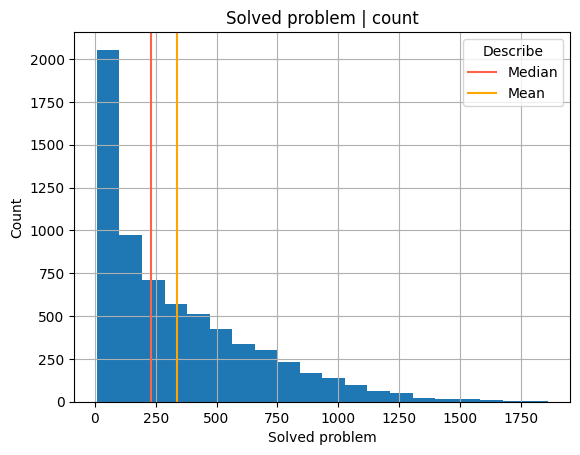

In [99]:
draw_user_group(user_group_train)

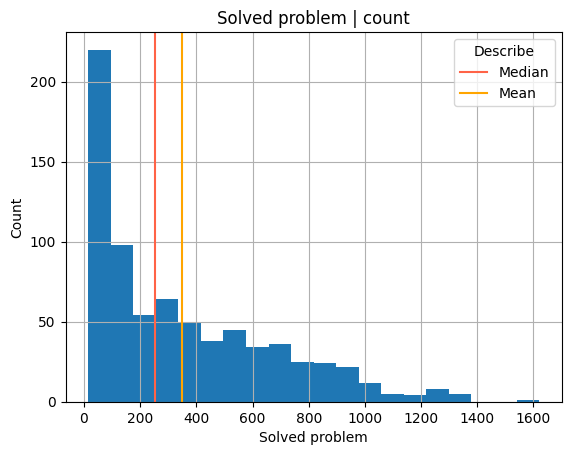

In [100]:
draw_user_group(user_group_test)

## 

In [30]:
pd.DataFrame(test_num_problem).describe().median()

0    336.177924
dtype: float64

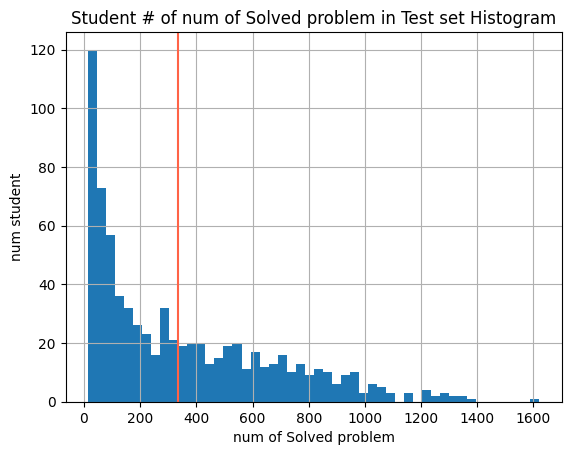

In [31]:
fig, ax = plt.subplots()

test_num_problem = test.groupby('userID')['answerCode'].count().sort_values()[::-1].values

pd.DataFrame(test_num_problem).hist(bins = 50, ax = ax)

ax.set_title("Student # of num of Solved problem in Test set Histogram")
ax.set_xlabel("num of Solved problem")
ax.set_ylabel("num student")
ax.axvline(pd.DataFrame(test_num_problem).describe().median().values,color = 'tomato')
ax.grid(visible=True)

In [22]:
set(test[test['answerCode'] == -1]['assessmentItemID']) - set(train["assessmentItemID"])

set()